# **Project:** Pathology Detection in Crop Plants

Members:
* Domenico Azzarito​
* Guillermo Bajo Laborda​
* Laura Alejandra Moreno​
* Arian Gharehmohammadzadehghashghaei​
* Michele Pezza


*Fundamentals of Data Science | Sapienza University of Rome*

In [91]:
#imports
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

## 1. EAD

## 2. CNN

In this step, the image data has been loaded, and also a normaliation, resizing and augmentation process has been implemented.

The key libraries used were TensorFlow for image processing, Pandas for handling the CSV files, and also os library. 



In [111]:
#data
data_dir = 'images/'  
sample_submission_csv = 'sample_submission.csv'
test_csv = 'test.csv'
train_csv = 'train.csv' 
train_df = pd.read_csv(train_csv)
print(train_df.columns)
train_df.columns = train_df.columns.str.strip()
print(train_df.head())

Index(['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')
  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0


In [112]:
# Convert the encoded labels into arrays
def con_process_labels(df):
    labels = df[['healthy', 'multiple_diseases', 'rust', 'scab']].values
    return labels
    

In [113]:
#Decode function to load and preprocess the image file

def decode_image(filename, label=None, image_size=(512, 512)):
    filepath = tf.strings.join([data_dir, filename])  
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.image.resize(image, image_size)
    print(f"decoded image shape: {image.shape}")
    image = tf.image.convert_image_dtype(image, tf.float32) 
    
    if label is None:
        return image
    else:
        return image, label



In [114]:
#Data augmentation to the images

def data_augmentation(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    if label is None:
        return image
    else:
        return image, label

In [115]:
#Create a Tensorflow dataset for testing

def prepare_dataset(df, image_size=(512, 512), batch_size=32, augment=False, is_train=True):
    file_paths = df['image_id'] + '.jpg'  
    
    if is_train:
        labels = con_process_labels(df) 
        dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
        dataset = dataset.map(lambda x, y: decode_image(x, y, image_size))  
    else:
        dataset = tf.data.Dataset.from_tensor_slices(file_paths)
        dataset = dataset.map(lambda x: decode_image(x, label=None, image_size=image_size))
    
    if augment and is_train:
        dataset = dataset.map(data_augmentation)  
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)  
    return dataset

In [116]:
# Create train dataset
train_dataset = prepare_dataset(train_df, image_size=image_size, augment=True, is_train=True)

decoded image shape: (512, 512, 3)


In [117]:
# Load test data
test_df = pd.read_csv(test_csv)
test_df.columns = test_df.columns.str.strip()  # Clean the column names for test set
test_dataset = prepare_dataset(test_df, image_size=(512, 512), augment=False, is_train=False)

decoded image shape: (512, 512, 3)


Image batch shape: (32, 512, 512, 3)
Label batch shape: (32, 4)
Image batch min and max values: -17.139069 284.97043
Image 0 range: min=-2.2991714477539062, max=268.9586486816406
Image 1 range: min=28.45008087158203, max=232.82144165039062
Image 2 range: min=15.806106567382812, max=246.37106323242188
Image 3 range: min=0.49831390380859375, max=265.38421630859375
Image 4 range: min=19.198104858398438, max=231.948486328125
Image 5 range: min=-6.865386962890625, max=273.37677001953125
Image 6 range: min=10.573051452636719, max=275.4283447265625
Image 7 range: min=6.0124664306640625, max=252.88070678710938
Image 8 range: min=-12.432632446289062, max=282.1144714355469


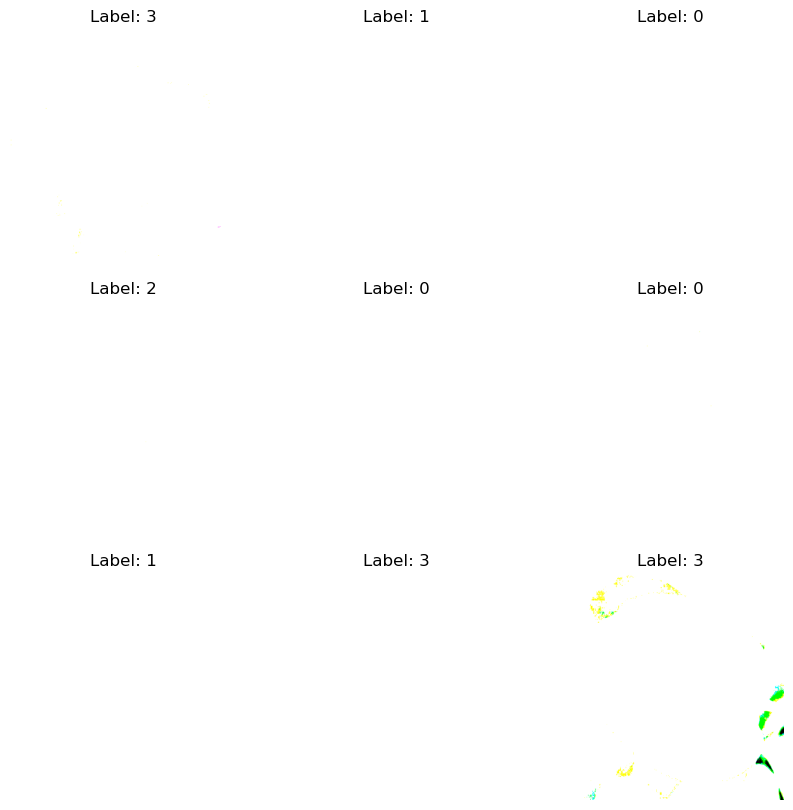

In [ ]:
#Verification 

for image_batch, label_batch in train_dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    
    # Check the min and max values of the entire image batch
    min_val = tf.reduce_min(image_batch).numpy()
    max_val = tf.reduce_max(image_batch).numpy()
    print("Image batch min and max values:", min_val, max_val)
    
    # Check if any image has invalid values (NaN or Inf)
    if tf.reduce_any(tf.math.is_nan(image_batch)):
        print("Warning: There are NaN values in the image batch.")
    if tf.reduce_any(tf.math.is_inf(image_batch)):
        print("Warning: There are Inf values in the image batch.")

    # Start plotting the first 9 images from the batch
    plt.figure(figsize=(10, 10))
    for i in range(9):  
        plt.subplot(3, 3, i+1)
        img = image_batch[i].numpy() 
        img_min = np.min(img)
        img_max = np.max(img)
        print(f"Image {i} range: min={img_min}, max={img_max}")
        
        # Check for NaN or Inf in individual image
        if np.any(np.isnan(img)):
            print(f"Warning: Image {i} contains NaN values.")
        if np.any(np.isinf(img)):
            print(f"Warning: Image {i} contains Inf values.")
        
        # Clip values to [0, 1] for normalization, then rescale to [0, 255]
        img = np.clip(img, 0, 1) 
        img = (img * 255).astype(np.uint8) 
        
        plt.imshow(img)
        plt.title(f"Label: {np.argmax(label_batch[i].numpy())}")
        plt.axis('off')
    
    plt.show()


# 3. Softmax Processing

In [123]:
#Extract histograms for R, G, B channels and vectorie them
def extract_color_histogram(image, bins=256):
   
    r_hist = tf.histogram_fixed_width(image[..., 0], [0.0, 1.0], nbins=bins)
    g_hist = tf.histogram_fixed_width(image[..., 1], [0.0, 1.0], nbins=bins)
    b_hist = tf.histogram_fixed_width(image[..., 2], [0.0, 1.0], nbins=bins)
    
    total_pixels = tf.size(image[..., 0], out_type=tf.float32)  
    r_hist = tf.cast(r_hist, tf.float32) / total_pixels
    g_hist = tf.cast(g_hist, tf.float32) / total_pixels
    b_hist = tf.cast(b_hist, tf.float32) / total_pixels
    
    color_histogram = tf.concat([r_hist, g_hist, b_hist], axis=-1)
    return color_histogram



In [ ]:
#List of historgrams

def prepare_color_histograms(df, image_size=(500, 500)):
    def process_image(filename):
        filepath = tf.strings.join([data_dir, filename])  
        bits = tf.io.read_file(filepath)
        image = tf.image.decode_jpeg(bits, channels=3)
        image = tf.image.resize(image, image_size)
        color_histogram = extract_color_histogram(image)
        return color_histogram

    file_paths = df['image_id'] + '.jpg'  
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(process_image)  #
    histograms = []
    
    for hist in dataset:
        histograms.append(hist.numpy())  
    return histograms  



In [128]:
def prepare_one_hot_labels(df):
    labels = df[['healthy', 'multiple_diseases', 'rust', 'scab']].values
    return labels


In [ ]:
# Prepare train dataset
train_histograms = prepare_color_histograms(train_df)
train_labels = prepare_one_hot_labels(train_df)
train_histograms_dataset = tf.data.Dataset.from_tensor_slices(train_histograms)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)
train_dataset = tf.data.Dataset.zip((train_histograms_dataset, train_labels_dataset))
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Prepare test dataset (no labelS, only histograms)
test_df = pd.read_csv(test_csv)
test_df.columns = test_df.columns.str.strip()
test_histograms = prepare_color_histograms(test_df)
test_histograms_dataset = tf.data.Dataset.from_tensor_slices(test_histograms)
test_dataset = test_histograms_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [89]:
for histograms, labels in train_dataset.take(1):
    print("Histograms:", histograms.numpy()[:5])
    print("Labels:", labels.numpy()[:5])

Histograms: [[0.       0.       0.       ... 0.       0.       0.999996]
 [0.       0.       0.       ... 0.       0.       1.      ]
 [0.       0.       0.       ... 0.       0.       1.      ]
 [0.       0.       0.       ... 0.       0.       1.      ]
 [0.       0.       0.       ... 0.       0.       1.      ]]
Labels: [[0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]]
